In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from pathlib import Path

import random

#from google.colab import drive
#drive.mount('/content/drive')

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [46]:
import importlib
try: 
    importlib.reload(data)
    importlib.reload(networks)
    importlib.reload(trainer)
    print("libs reloaded")
except:
    import data 
    import networks 
    import trainer
    import utils
    print("libs imported")

VAE = networks.VAE
TrainerMaskVAE = trainer.TrainerMaskVAE

libs imported


# Mask VAE

In [47]:
WORKING_DIR = Path(r"C:\Users\20192024\OneDrive - TU Eindhoven\Documents\Y4\Q3\Capita Selecta in Medical Image Analysis\Project\Nieuw")
DATA_DIR = WORKING_DIR / "TrainingData"
PROGRESS_DIR_VAE = WORKING_DIR / "progress_vae"
PROGRESS_DIR_VAE.mkdir(parents=True, exist_ok=True)
TENSORBOARD_LOGDIR = "vae_runs"

N = 15
NO_VALIDATION_PATIENTS = 3
train_size = N-NO_VALIDATION_PATIENTS
seed = 0
IMAGE_SIZE = [64,64]

Z_DIM = 2

BATCH_SIZE = 32
N_EPOCHS = 100
DECAY_LR_AFTER = 50
LEARNING_RATE = 1e-3

exp = str(N_EPOCHS) + 'epochs_' + str(Z_DIM) + 'zdim'
EXPERIMENT_DIR = PROGRESS_DIR_VAE / exp
EXPERIMENT_DIR.mkdir(parents=True, exist_ok=True)

#nADAM instead of adam

OPTIMIZER = lambda parameters, lr : torch.optim.NAdam(parameters, lr=lr, betas=(0.5,0.999))
#OPTIMIZER = lambda parameters, lr : torch.optim.RMSprop(
#    parameters,
#    lr=lr,
#    alpha=0.9,
#    eps=1e-8,
#    weight_decay=0,
#    momentum=0,
#    centered=False
#)

# loewr epochs increases weights faster
KLD_ANNEALING_EPOCHS = 25

def lambda_lr(the_epoch):
    return (
        1.0
        if the_epoch < DECAY_LR_AFTER
        else 1 - float(the_epoch - DECAY_LR_AFTER) / (N_EPOCHS - DECAY_LR_AFTER)
    )

In [48]:
utils.remove_empty_masks(DATA_DIR)

In [49]:
# find patient folders in training directory
# excluding hidden folders (start with .)

patients = [
    path
    for path in DATA_DIR.glob("*")
    if not any(part.startswith(".") for part in path.parts)
]

train_indx, valid_indx = train_test_split(patients, random_state=seed, train_size=train_size)

# split in training/validation after shuffling
partition = {
    "train": train_indx,
    "validation": valid_indx,
}
# load training data and create DataLoader with batching and shuffling
train_set = data.ProstateMRMaskDataset(partition["train"], IMAGE_SIZE)
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

# load validation data
valid_set = data.ProstateMRMaskDataset(partition["validation"], IMAGE_SIZE)
valid_loader = DataLoader(
    valid_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

transform = transforms.Compose([
     transforms.RandomRotation((-6.,+6.), interpolation=transforms.InterpolationMode.NEAREST),
     transforms.RandomResizedCrop((64,64), scale=(0.8,1.), ratio=(1,1), interpolation=transforms.InterpolationMode.NEAREST, antialias=True)
 ])

train_set.transform = transform
    
train_set.labels = train_set.labels[:,0:1]
valid_set.labels = valid_set.labels[:,0:1]

In [50]:
vae_model = VAE(spade=False).to(device)
optimizer = OPTIMIZER(vae_model.parameters(), lr=LEARNING_RATE)
vae_trainer = TrainerMaskVAE(
    vae_model,
    optimizer,
    KLD_ANNEALING_EPOCHS,
    PROGRESS_DIR_VAE,
    train_loader,
    valid_loader,
    device,
)

In [51]:
vae_trainer.train(N_EPOCHS, lambda_lr=lambda_lr)

100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch #0: Rec_Loss/train = 0.61118, KLD/train = 4.35843 | Rec_Loss/valid = 0.52650, KLD/valid = 3.87015


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch #1: Rec_Loss/train = 0.45745, KLD/train = 6.70519 | Rec_Loss/valid = 0.42332, KLD/valid = 3.71165


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch #2: Rec_Loss/train = 0.41913, KLD/train = 3.39076 | Rec_Loss/valid = 0.44730, KLD/valid = 2.83288


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch #3: Rec_Loss/train = 0.37662, KLD/train = 2.23999 | Rec_Loss/valid = 0.33086, KLD/valid = 1.11154


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch #4: Rec_Loss/train = 0.30917, KLD/train = 1.28620 | Rec_Loss/valid = 0.31315, KLD/valid = 0.92733


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch #5: Rec_Loss/train = 0.27043, KLD/train = 0.93519 | Rec_Loss/valid = 0.30240, KLD/valid = 0.53948


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch #6: Rec_Loss/train = 0.28261, KLD/train = 0.90145 | Rec_Loss/valid = 0.29692, KLD/valid = 0.43279


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Epoch #7: Rec_Loss/train = 0.27946, KLD/train = 0.60587 | Rec_Loss/valid = 0.26465, KLD/valid = 0.19845


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch #8: Rec_Loss/train = 0.24427, KLD/train = 0.38585 | Rec_Loss/valid = 0.19510, KLD/valid = 0.20964


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Epoch #9: Rec_Loss/train = 0.25558, KLD/train = 0.32226 | Rec_Loss/valid = 0.36779, KLD/valid = 0.25483


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Epoch #10: Rec_Loss/train = 0.22623, KLD/train = 0.22376 | Rec_Loss/valid = 0.23759, KLD/valid = 0.12634


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Epoch #11: Rec_Loss/train = 0.23846, KLD/train = 0.16290 | Rec_Loss/valid = 0.20855, KLD/valid = 0.12654


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch #12: Rec_Loss/train = 0.23547, KLD/train = 0.13491 | Rec_Loss/valid = 0.21531, KLD/valid = 0.08026


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch #13: Rec_Loss/train = 0.21308, KLD/train = 0.09955 | Rec_Loss/valid = 0.31495, KLD/valid = 0.13843


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch #14: Rec_Loss/train = 0.50257, KLD/train = 57.52996 | Rec_Loss/valid = 0.71064, KLD/valid = 3.53064


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch #15: Rec_Loss/train = 0.48470, KLD/train = 1.56354 | Rec_Loss/valid = 0.49399, KLD/valid = 1.06193


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch #16: Rec_Loss/train = 0.42786, KLD/train = 1.00515 | Rec_Loss/valid = 0.37828, KLD/valid = 0.59710


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch #17: Rec_Loss/train = 0.40826, KLD/train = 0.72672 | Rec_Loss/valid = 0.34743, KLD/valid = 0.70174


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch #18: Rec_Loss/train = 0.41997, KLD/train = 0.64338 | Rec_Loss/valid = 0.39461, KLD/valid = 0.98366


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch #19: Rec_Loss/train = 0.37442, KLD/train = 0.50714 | Rec_Loss/valid = 0.30225, KLD/valid = 0.36419


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch #20: Rec_Loss/train = 0.34717, KLD/train = 0.40129 | Rec_Loss/valid = 0.44530, KLD/valid = 1.43326


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch #21: Rec_Loss/train = 0.35728, KLD/train = 0.48269 | Rec_Loss/valid = 0.32848, KLD/valid = 0.31642


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch #22: Rec_Loss/train = 0.32603, KLD/train = 0.32875 | Rec_Loss/valid = 0.27917, KLD/valid = 0.28281


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch #23: Rec_Loss/train = 0.33267, KLD/train = 0.35904 | Rec_Loss/valid = 0.25971, KLD/valid = 0.23731


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch #24: Rec_Loss/train = 0.31001, KLD/train = 0.32841 | Rec_Loss/valid = 0.28366, KLD/valid = 0.20762


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch #25: Rec_Loss/train = 0.29474, KLD/train = 0.25421 | Rec_Loss/valid = 0.25121, KLD/valid = 0.23588


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch #26: Rec_Loss/train = 0.28617, KLD/train = 0.24086 | Rec_Loss/valid = 0.32415, KLD/valid = 0.18516


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch #27: Rec_Loss/train = 0.26919, KLD/train = 0.25137 | Rec_Loss/valid = 0.27648, KLD/valid = 0.17222


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch #28: Rec_Loss/train = 0.27168, KLD/train = 0.22526 | Rec_Loss/valid = 0.30460, KLD/valid = 0.17487


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch #29: Rec_Loss/train = 0.25170, KLD/train = 0.19887 | Rec_Loss/valid = 0.24528, KLD/valid = 0.17762


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch #30: Rec_Loss/train = 0.24911, KLD/train = 0.19580 | Rec_Loss/valid = 0.30306, KLD/valid = 0.26657


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch #31: Rec_Loss/train = 0.24845, KLD/train = 0.21110 | Rec_Loss/valid = 0.28345, KLD/valid = 0.19029


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch #32: Rec_Loss/train = 0.25243, KLD/train = 0.19550 | Rec_Loss/valid = 0.29553, KLD/valid = 0.18861


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch #33: Rec_Loss/train = 0.24687, KLD/train = 0.20472 | Rec_Loss/valid = 0.36126, KLD/valid = 0.18795


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch #34: Rec_Loss/train = 0.23174, KLD/train = 0.17759 | Rec_Loss/valid = 0.33913, KLD/valid = 0.21641


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch #35: Rec_Loss/train = 0.24523, KLD/train = 0.18225 | Rec_Loss/valid = 0.29602, KLD/valid = 0.17011


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch #36: Rec_Loss/train = 0.23754, KLD/train = 0.19027 | Rec_Loss/valid = 0.21537, KLD/valid = 0.13582


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch #37: Rec_Loss/train = 0.21453, KLD/train = 0.15435 | Rec_Loss/valid = 0.24863, KLD/valid = 0.11986


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch #38: Rec_Loss/train = 0.23057, KLD/train = 0.17636 | Rec_Loss/valid = 0.28515, KLD/valid = 0.24651


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch #39: Rec_Loss/train = 0.22271, KLD/train = 0.17459 | Rec_Loss/valid = 0.30237, KLD/valid = 0.16259


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch #40: Rec_Loss/train = 0.21999, KLD/train = 0.16251 | Rec_Loss/valid = 0.26349, KLD/valid = 0.13919


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch #41: Rec_Loss/train = 0.20849, KLD/train = 0.15603 | Rec_Loss/valid = 0.25394, KLD/valid = 0.15414


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch #42: Rec_Loss/train = 0.21063, KLD/train = 0.15408 | Rec_Loss/valid = 0.23001, KLD/valid = 0.18271


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch #43: Rec_Loss/train = 0.20524, KLD/train = 0.15572 | Rec_Loss/valid = 0.21827, KLD/valid = 0.14170


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch #44: Rec_Loss/train = 0.20722, KLD/train = 0.15494 | Rec_Loss/valid = 0.21212, KLD/valid = 0.18247


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch #45: Rec_Loss/train = 0.20116, KLD/train = 0.15279 | Rec_Loss/valid = 0.30504, KLD/valid = 0.20689


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch #46: Rec_Loss/train = 0.19640, KLD/train = 0.14848 | Rec_Loss/valid = 0.21030, KLD/valid = 0.10200


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch #47: Rec_Loss/train = 0.18790, KLD/train = 0.13787 | Rec_Loss/valid = 0.20920, KLD/valid = 0.12554


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch #48: Rec_Loss/train = 0.20341, KLD/train = 0.15142 | Rec_Loss/valid = 0.21638, KLD/valid = 0.12823


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch #49: Rec_Loss/train = 0.19214, KLD/train = 0.14441 | Rec_Loss/valid = 0.25372, KLD/valid = 0.13557


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch #50: Rec_Loss/train = 0.18436, KLD/train = 0.13011 | Rec_Loss/valid = 0.22877, KLD/valid = 0.11221


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch #51: Rec_Loss/train = 0.18788, KLD/train = 0.13294 | Rec_Loss/valid = 0.20215, KLD/valid = 0.08408


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch #52: Rec_Loss/train = 0.18501, KLD/train = 0.12558 | Rec_Loss/valid = 0.23078, KLD/valid = 0.10847


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch #53: Rec_Loss/train = 0.16775, KLD/train = 0.11367 | Rec_Loss/valid = 0.25789, KLD/valid = 0.15704


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch #54: Rec_Loss/train = 0.17734, KLD/train = 0.11738 | Rec_Loss/valid = 0.21571, KLD/valid = 0.08360


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch #55: Rec_Loss/train = 0.17007, KLD/train = 0.10553 | Rec_Loss/valid = 0.27820, KLD/valid = 0.16973


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch #56: Rec_Loss/train = 0.16559, KLD/train = 0.10820 | Rec_Loss/valid = 0.17922, KLD/valid = 0.07844


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch #57: Rec_Loss/train = 0.16325, KLD/train = 0.10105 | Rec_Loss/valid = 0.18856, KLD/valid = 0.10490


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch #58: Rec_Loss/train = 0.16198, KLD/train = 0.10753 | Rec_Loss/valid = 0.20688, KLD/valid = 0.09158


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch #59: Rec_Loss/train = 0.15289, KLD/train = 0.09826 | Rec_Loss/valid = 0.20760, KLD/valid = 0.07552


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch #60: Rec_Loss/train = 0.14938, KLD/train = 0.09516 | Rec_Loss/valid = 0.23001, KLD/valid = 0.08910


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch #61: Rec_Loss/train = 0.15094, KLD/train = 0.09069 | Rec_Loss/valid = 0.19991, KLD/valid = 0.08721


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch #62: Rec_Loss/train = 0.14918, KLD/train = 0.09169 | Rec_Loss/valid = 0.18781, KLD/valid = 0.08617


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch #63: Rec_Loss/train = 0.14342, KLD/train = 0.08967 | Rec_Loss/valid = 0.17906, KLD/valid = 0.08002


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch #64: Rec_Loss/train = 0.14132, KLD/train = 0.08400 | Rec_Loss/valid = 0.21350, KLD/valid = 0.07320


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch #65: Rec_Loss/train = 0.14625, KLD/train = 0.08356 | Rec_Loss/valid = 0.19349, KLD/valid = 0.09461


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch #66: Rec_Loss/train = 0.13684, KLD/train = 0.08438 | Rec_Loss/valid = 0.19311, KLD/valid = 0.07243


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch #67: Rec_Loss/train = 0.12994, KLD/train = 0.08069 | Rec_Loss/valid = 0.16749, KLD/valid = 0.06726


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch #68: Rec_Loss/train = 0.13173, KLD/train = 0.07926 | Rec_Loss/valid = 0.18364, KLD/valid = 0.07836


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch #69: Rec_Loss/train = 0.12983, KLD/train = 0.07872 | Rec_Loss/valid = 0.16727, KLD/valid = 0.06025


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch #70: Rec_Loss/train = 0.13130, KLD/train = 0.07804 | Rec_Loss/valid = 0.21006, KLD/valid = 0.07718


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch #71: Rec_Loss/train = 0.13052, KLD/train = 0.07656 | Rec_Loss/valid = 0.18064, KLD/valid = 0.06632


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch #72: Rec_Loss/train = 0.12325, KLD/train = 0.07331 | Rec_Loss/valid = 0.19406, KLD/valid = 0.07104


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch #73: Rec_Loss/train = 0.12499, KLD/train = 0.07282 | Rec_Loss/valid = 0.19890, KLD/valid = 0.06013


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch #74: Rec_Loss/train = 0.12204, KLD/train = 0.07327 | Rec_Loss/valid = 0.17687, KLD/valid = 0.06630


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch #75: Rec_Loss/train = 0.11794, KLD/train = 0.07031 | Rec_Loss/valid = 0.18683, KLD/valid = 0.06282


100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch #76: Rec_Loss/train = 0.12219, KLD/train = 0.07118 | Rec_Loss/valid = 0.17296, KLD/valid = 0.06475


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch #77: Rec_Loss/train = 0.11777, KLD/train = 0.07053 | Rec_Loss/valid = 0.16828, KLD/valid = 0.06057


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch #78: Rec_Loss/train = 0.11582, KLD/train = 0.06891 | Rec_Loss/valid = 0.17142, KLD/valid = 0.06475


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch #79: Rec_Loss/train = 0.11472, KLD/train = 0.06897 | Rec_Loss/valid = 0.16932, KLD/valid = 0.06000


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch #80: Rec_Loss/train = 0.10962, KLD/train = 0.06812 | Rec_Loss/valid = 0.16394, KLD/valid = 0.06018


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch #81: Rec_Loss/train = 0.10584, KLD/train = 0.06773 | Rec_Loss/valid = 0.16335, KLD/valid = 0.05816


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch #82: Rec_Loss/train = 0.10828, KLD/train = 0.06607 | Rec_Loss/valid = 0.16158, KLD/valid = 0.05992


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch #83: Rec_Loss/train = 0.10561, KLD/train = 0.06509 | Rec_Loss/valid = 0.17586, KLD/valid = 0.06181


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch #84: Rec_Loss/train = 0.10443, KLD/train = 0.06550 | Rec_Loss/valid = 0.16141, KLD/valid = 0.05774


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch #85: Rec_Loss/train = 0.10472, KLD/train = 0.06435 | Rec_Loss/valid = 0.15767, KLD/valid = 0.05605


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch #86: Rec_Loss/train = 0.10133, KLD/train = 0.06323 | Rec_Loss/valid = 0.15656, KLD/valid = 0.05481


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Epoch #87: Rec_Loss/train = 0.10032, KLD/train = 0.06349 | Rec_Loss/valid = 0.15983, KLD/valid = 0.05620


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch #88: Rec_Loss/train = 0.10009, KLD/train = 0.06372 | Rec_Loss/valid = 0.16529, KLD/valid = 0.05783


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch #89: Rec_Loss/train = 0.09817, KLD/train = 0.06246 | Rec_Loss/valid = 0.15497, KLD/valid = 0.05643


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Epoch #90: Rec_Loss/train = 0.09730, KLD/train = 0.06280 | Rec_Loss/valid = 0.16117, KLD/valid = 0.05542


100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


Epoch #91: Rec_Loss/train = 0.09630, KLD/train = 0.06141 | Rec_Loss/valid = 0.15506, KLD/valid = 0.05580


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch #92: Rec_Loss/train = 0.09509, KLD/train = 0.06150 | Rec_Loss/valid = 0.15927, KLD/valid = 0.05403


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch #93: Rec_Loss/train = 0.09604, KLD/train = 0.06172 | Rec_Loss/valid = 0.15657, KLD/valid = 0.05580


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch #94: Rec_Loss/train = 0.09302, KLD/train = 0.06247 | Rec_Loss/valid = 0.15053, KLD/valid = 0.05607


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch #95: Rec_Loss/train = 0.09209, KLD/train = 0.06202 | Rec_Loss/valid = 0.15231, KLD/valid = 0.05560


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch #96: Rec_Loss/train = 0.09293, KLD/train = 0.06125 | Rec_Loss/valid = 0.15528, KLD/valid = 0.05590


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch #97: Rec_Loss/train = 0.09113, KLD/train = 0.06091 | Rec_Loss/valid = 0.15716, KLD/valid = 0.05594


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch #98: Rec_Loss/train = 0.09068, KLD/train = 0.06086 | Rec_Loss/valid = 0.15623, KLD/valid = 0.05548


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch #99: Rec_Loss/train = 0.08919, KLD/train = 0.06060 | Rec_Loss/valid = 0.15368, KLD/valid = 0.05468


### Plot reconstruction loss

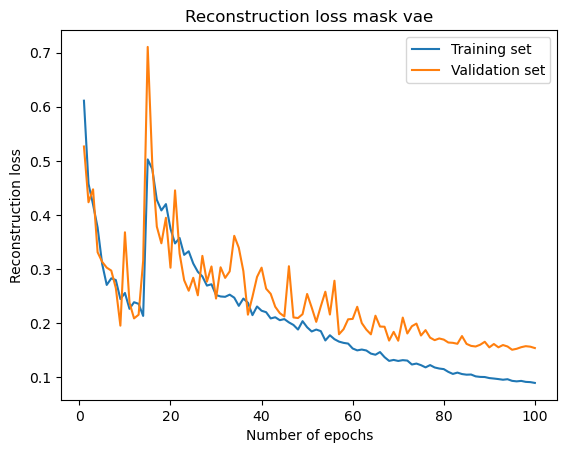

In [52]:
plt.plot(range(1,N_EPOCHS+1), vae_trainer.train_losses[0])
plt.plot(range(1,N_EPOCHS+1), vae_trainer.valid_losses[0])
plt.xlabel('Number of epochs')
plt.ylabel('Reconstruction loss')
plt.title('Reconstruction loss mask vae')
plt.legend(['Training set', 'Validation set'])
plot_name = 'RECON_LOSS'+str(N_EPOCHS) + 'epochs_' + str(Z_DIM) + '_latentdim.png'
path = EXPERIMENT_DIR / plot_name

plt.savefig(path, dpi=200)

### Plot KLD loss

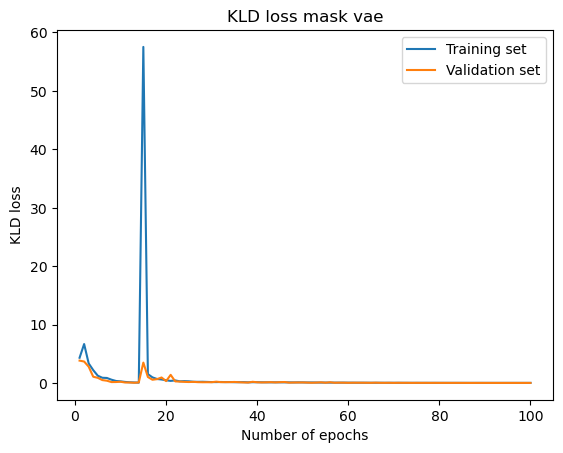

In [53]:
plt.plot(range(1,N_EPOCHS+1), vae_trainer.train_losses[1])
plt.plot(range(1,N_EPOCHS+1), vae_trainer.valid_losses[1])
plt.ylabel('KLD loss')
plt.xlabel('Number of epochs')
plt.title('KLD loss mask vae')
plt.legend(['Training set', 'Validation set'])
plot_name = 'KLD_LOSS'+str(N_EPOCHS) + 'epochs_' + str(Z_DIM) + '_latentdim.png'
path = EXPERIMENT_DIR / plot_name

plt.savefig(path, dpi=200)

### Plot losses together (sum)

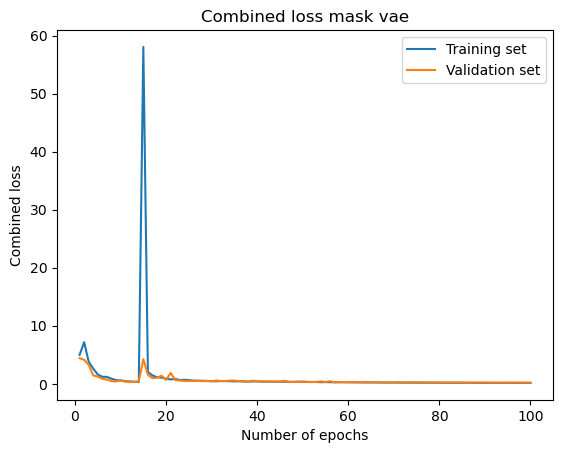

In [54]:
plt.plot(range(1,N_EPOCHS+1), [sum(x) for x in zip(*vae_trainer.train_losses)])
plt.plot(range(1,N_EPOCHS+1), [sum(x) for x in zip(*vae_trainer.valid_losses)])
plt.ylabel('Combined loss')
plt.xlabel('Number of epochs')
plt.title('Combined loss mask vae')
plt.legend(['Training set', 'Validation set'])
plot_name = 'COMBINED_LOSS'+str(N_EPOCHS) + 'epochs_' + str(Z_DIM) + '_latentdim.png'
path = EXPERIMENT_DIR / plot_name

plt.savefig(path, dpi=200)

### Save losses in .txt files

In [55]:
TRAIN_DIR = EXPERIMENT_DIR / 'training'
VALID_DIR = EXPERIMENT_DIR / 'validation'
TRAIN_DIR.mkdir(parents=True, exist_ok=True)
VALID_DIR.mkdir(parents=True, exist_ok=True)

filename = str(N_EPOCHS) + 'epochs_' + str(Z_DIM) + '_latentdim.txt' 

file_train = open(TRAIN_DIR / filename, 'w')
file_valid = open(VALID_DIR / filename,'w')

for i, j in zip(vae_trainer.train_losses, vae_trainer.valid_losses):
    file_train.write("{loss}\n".format(loss=i))
    file_valid.write("{loss}\n".format(loss=j))

file_train.close()
file_valid.close()


### Save model weights & optimizer

In [56]:
for param_tensor in vae_model.state_dict():
    print(param_tensor, "\t", vae_model.state_dict()[param_tensor].size())

encoder.conv1.weight 	 torch.Size([32, 1, 7, 7])
encoder.conv1.bias 	 torch.Size([32])
encoder.layer1.0.conv1.weight 	 torch.Size([32, 32, 3, 3])
encoder.layer1.0.conv2.weight 	 torch.Size([32, 32, 3, 3])
encoder.layer2.0.conv1.weight 	 torch.Size([64, 32, 3, 3])
encoder.layer2.0.conv2.weight 	 torch.Size([64, 64, 3, 3])
encoder.layer2.0.convsc.weight 	 torch.Size([64, 32, 1, 1])
encoder.layer2.0.convsc.bias 	 torch.Size([64])
encoder.layer3.0.conv1.weight 	 torch.Size([128, 64, 3, 3])
encoder.layer3.0.conv2.weight 	 torch.Size([128, 128, 3, 3])
encoder.layer3.0.convsc.weight 	 torch.Size([128, 64, 1, 1])
encoder.layer3.0.convsc.bias 	 torch.Size([128])
encoder.layer4.0.conv1.weight 	 torch.Size([256, 128, 3, 3])
encoder.layer4.0.conv2.weight 	 torch.Size([256, 256, 3, 3])
encoder.layer4.0.convsc.weight 	 torch.Size([256, 128, 1, 1])
encoder.layer4.0.convsc.bias 	 torch.Size([256])
encoder.final.1.weight 	 torch.Size([512, 4096])
encoder.final.1.bias 	 torch.Size([512])
generator.proj_

In [57]:
# Question: how to make sure it only saves best model according to validation loss?
# It is mentioned here but cannot make sense of it: https://pytorch.org/tutorials/beginner/saving_loading_models.html


PATH_model = os.path.join(EXPERIMENT_DIR, 'model.pt' )
PATH_opt = os.path.join(EXPERIMENT_DIR, 'opt.pt' )

torch.save(vae_model.state_dict(), PATH_model)
torch.save(optimizer.state_dict(), PATH_opt)

model = vae_model
model.load_state_dict(torch.load(PATH_model))
model.eval()

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (bn1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu1): LeakyReLU(negative_slope=0.2, inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ModuleList(
      (0): ResidualBlock(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): LeakyReLU(negative_slope=0.2, inplace=True)
        (bn1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
    )
    (layer2): ModuleList(
      (0): ResidualBlock(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b